# Chapter 6: Advanced Text Generation Strategies

<div class="alert alert-block alert-success">
In the previous chapter, we successfully trained our GPT model. To generate text, we used **greedy decoding** (always picking the single most likely token with `argmax`). While functional, this approach is deterministic and often leads to repetitive and boring text.

To generate more creative and varied responses, we need to introduce controlled randomness by sampling from the model's predicted probability distribution. This chapter will cover two popular techniques to control this sampling process:

1.  **Temperature Scaling:** To make the model's predictions more or less random.
2.  **Top-k Sampling:** To restrict the sampling pool to plausible tokens, avoiding nonsensical words.

Finally, we'll combine these into a new, more powerful `generate` function.
</div>

## 6.1 Import and Setup: Loading the Trained Model

<div class="alert alert-block alert-success">
    
For these demonstrations, we need a trained model. We will load the model that was saved at the end of Chapter 5. We will also set it up on the CPU for inference, as a powerful GPU is not required for generating short text samples.
</div>

In [1]:
# --- Imports and Setup ---
import sys
import os

import torch
import tiktoken
import matplotlib.pyplot as plt

# --- Add Project Root to Python Path ---

# Get the directory of the current notebook
current_notebook_dir = os.getcwd()

# Go up one level to the project's root directory
project_root = os.path.abspath(os.path.join(current_notebook_dir, '..'))

# Add the project root to the Python path if it's not already there
if project_root not in sys.path:
    sys.path.append(project_root)

# --- Imports from your `src` package ---
from src.model import GPTModel, TransformerBlock
from src.layers import LayerNorm, GELU, FeedForward
from src.text_generation import generate_text_simple
from src.config import GPT_CONFIG_124M_SMALL
from src.utils import text_to_token_ids, token_ids_to_text

# --- Load the Trained Model ---
model = GPTModel(GPT_CONFIG_124M_SMALL)
# Replace with the actual path to your saved model from Chapter 5
model.load_state_dict(torch.load("../models/model.pth")) 
model.eval() # Set to evaluation mode

print("Trained model loaded successfully.")

Trained model loaded successfully.


## 6.2 Beyond Greedy Decoding: Probabilistic Sampling

<div class="alert alert-block alert-success">

First, we briefly revisit the generate_text_simple function from the previous chapter.

Then, we will cover two techniques, **temperature scaling**, and **top-k sampling**, to improve this function.
</div>

<div class="alert alert-block alert-success">
    
Greedy decoding is limited because it always chooses the same path. To add variety, we can sample from the probability distribution using `torch.multinomial`. This function selects a token based on its probability, so higher-probability tokens are chosen more often, but lower-probability ones still have a chance.
</div>

<div class="alert alert-block alert-success">

Let's start by plugging the GPTModel trained instance (`model`) into the `generate_text_simple` function, which uses the LLM to generate a token at a time:
</div>

In [2]:
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M_SMALL["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the fact with equanimity. Gisburn's an awful simpleton


In [3]:
# Get the device of the first parameter
device = next(model.parameters()).device

# Print the device
print(f"The model is on: {device}")

The model is on: cpu


## 6.3 Beyond Greedy Decoding: Probabilistic Sampling

<div class="alert alert-block alert-success">

Greedy decoding is limited because it always chooses the same path. To add variety, we can sample from the probability distribution using `torch.multinomial`. This function selects a token based on its probability, so higher-probability tokens are chosen more often, but lower-probability ones still have a chance.

To illustrate the probabilistic sampling with a concrete example, let's briefly discuss the next-token generation process using a very small vocabulary for illustration purposes:
</div>

In [4]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 

inverse_vocab = {v: k for k, v in vocab.items()}

<div class="alert alert-block alert-success">

Let's assume our LLM is given the start context "every effort moves you" and generates the following next-token logits:
</div>

In [5]:
next_token_logits = torch.tensor(
[4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

<div class="alert alert-block alert-success">

Then we convert the logits into probabilities via the softmax function and obtain the token ID corresponding the generated token via the argmax function, which we can then map back into text via the inverse vocabulary:
</div>

In [6]:
probas = torch.softmax(next_token_logits, dim=0)

print("Probabilities:", probas)

next_token_id = torch.argmax(probas).item()

print("Next token ID:", next_token_id)

print("Word corresponding to next token ID:", inverse_vocab[next_token_id])

Probabilities: tensor([6.0907e-02, 1.6313e-03, 1.0019e-04, 5.7212e-01, 3.4190e-03, 1.3257e-04,
        1.0120e-04, 3.5758e-01, 4.0122e-03])
Next token ID: 3
Word corresponding to next token ID: forward


<div class="alert alert-block alert-success">

To implement a probabilistic sampling process, we can now replace the argmax with the `multinomial` function in PyTorch:
</div>

In [7]:
torch.manual_seed(100)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print("Word corresponding to next token:", inverse_vocab[next_token_id])

Word corresponding to next token: forward


<div class="alert alert-block alert-success">

The printed output is "forward" just like before. **What happened?** The multinomial function samples the next token proportional to its probability score. 

In other words, "forward" is still the most likely token and will be selected by multinomial most of the time but not all the time. 

To illustrate this, let's implement a function that repeats this sampling 1000 times:

</div>

In [8]:
def print_sampled_tokens(probas):
    torch.manual_seed(100) # Manual seed for reproducibility
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

69 x closer
2 x every
0 x effort
569 x forward
8 x inches
0 x moves
0 x pizza
347 x toward
5 x you


<div class="alert alert-block alert-info">

As we can see based on the output, the word "forward" is sampled most of the time (569 out of 1000 times), but other tokens such as "closer", "inches", and "toward" will also be sampled some of the time. 

This means that if we replaced the argmax function with the multinomial function inside the `generate_and_print_sample` function that we defined in Chapter 5, the LLM would sometimes generate texts such as "every effort moves you toward", "every effort moves you inches", and "every effort moves you closer" instead of "every effort moves you forward".
</div>

## 6.3 Decoding Strategy 1: Temperature Scaling

<div class="alert alert-block alert-success">

We can further control the "randomness" of our generated text with **temperature scaling**. We simply divide the logits by a temperature value before the softmax function.

Let's illustrate this by plotting the original probabilities alongside probabilities scaled with different temperature values:
</div>

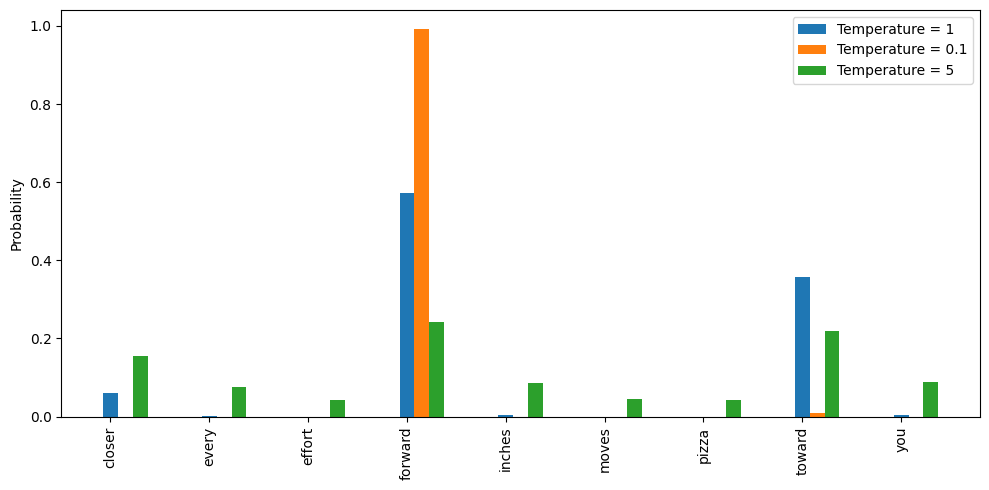

In [9]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# Temperature values
temperatures = [1, 0.1, 5]  # Original, higher confidence, and lower confidence

# Calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(10, 5))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

<div class="alert alert-block alert-info">
    
**A Note on Temperature**

Temperature scaling controls the randomness of the text generation. Think of temperature as a "creativity" knob:

* A **low temperature (&lt; 1.0)** makes the distribution sharper. The model becomes more confident and conservative, similar to greedy decoding.

* A **temperature of 1** is the default and uses the standard softmax probabilities for sampling.

* A **high temperature (&gt; 1.0)** makes the distribution flatter. The model takes more risks, giving lower-probability tokens a higher chance. This increases creativity but also the risk of errors.

For example, using the temperature of 5 results in texts such as **"every effort moves you pizza"** about **4% of the time**.
</div>

## 6.4 Decoding Strategy 2: Top-k Sampling

<div class="alert alert-block alert-success">

A downside of high temperature is that it can sample completely nonsensical tokens. **Top-k sampling** fixes this by limiting the sampling pool to only the `k` most likely tokens and exclude all other tokens from the selection process by masking their probability scores. This provides a great balance between creativity and coherence.
</div>

In [10]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


<div class="alert alert-block alert-success">

Subsequently, we apply PyTorch's `where` function to set the logit values of tokens that are below the lowest logit value within our **top-3** selection to negative infinity (`-inf`).
</div>

In [11]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float("-inf")), 
    other=next_token_logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


<div class="alert alert-block alert-success">

Lastly, let's apply the `softmax` function to turn these into next-token probabilities:
</div>

In [12]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


## 6.5 The Final `generate` Function - Merging Temperature Scaling and Top-k Sampling

<div class="alert alert-block alert-success">

Now, let's combine all these concepts—probabilistic sampling (`torch.multinomial`), temperature scaling, and top-k filtering—into a final, powerful `generate` function.
</div>

In [13]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

<div class="alert alert-block alert-success">

Let's now see this new `generate` function in action:
</div>

In [14]:
torch.manual_seed(100)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M_SMALL["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you sunburnt cheeks furrow, as a feather't let all the Riv


<div class="alert alert-block alert-info">

As we can see, the generated text is very different from the one we previously generated
via the generate_simple function earlier (**"Every effort moves you? Yes--quite insensible to [...]"**), which was a memorized passage from the training set.
</div>

<div class="alert alert-block alert-success">
    
## 6.6 Chapter 6 Summary and Next Steps
    
This concludes our exploration of advanced text generation techniques. We've moved beyond the deterministic "greedy" approach and implemented the sophisticated sampling strategies that give modern LLMs their creative and nuanced voice.

<div class="alert alert-block alert-info">
 
**Milestone Reached: Creative Text Generation Unlocked!**

Throughout this chapter, we have:

* Understood the limitations of greedy decoding and implemented **probabilistic sampling** using `torch.multinomial`.
* Learned how to control the creativity of the output using **Temperature Scaling**.
* Used **Top-k Sampling** to maintain coherence and prevent the model from generating nonsensical tokens.
* Combined these strategies into a final, powerful `generate` function that offers fine-grained control over the text generation process.
 
</div>

### Where We Are Now

We now have a trained GPT model and a sophisticated generation function. We can not only generate coherent text but also control its style—from conservative and predictable to creative and surprising—by tuning the `temperature` and `top_k` parameters.

### What's Next?

Our from-scratch model and generation pipeline are now fully functional. The next logical step is to see how our implementation stacks up against a professionally trained model. In the next notebook, **Chapter 7: Loading Pre-trained GPT-2 Weights**, we will download the official weights from OpenAI and load them into our own `GPTModel` architecture. This will be the ultimate test of our work.
</div>